This notebook showcases how the data for pytorch captioning tutorial was originally obtained.

Running this script is not necessary to complete the basic assignment as __you will be given preprocessed data__ produced by this notebook. The script itself takes hours

However, if one wants to implement e.g. attentive captioning with attention casted into earlier layers in the network OR try a different network architecture, one is invited to change this code at will. 
GPU(s), high-speed internet and ~50G of disc space are recommended.

In [1]:
# Obtaining the data:
# download stuff from http://cocodataset.org/#download
#!curl http://images.cocodataset.org/zips/train2017.zip > train2017.zip
#!curl http://images.cocodataset.org/zips/val2017.zip > val2017.zip
#!curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip > annotations_trainval2017.zip

#!unzip -o annotations_trainval2017.zip
#!unzip -o train2017.zip > log
#!unzip -o val2017.zip > log

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  92.9M      0  0:00:02  0:00:02 --:--:-- 92.9M
Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [2]:
# sanity check
!du -h --max-depth=1 .

296K	./.ipynb_checkpoints
788M	./val2017
19G	./train2017
796M	./annotations
39G	.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%env CUDA_VISIBLE_DEVICES=1,2
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

env: CUDA_VISIBLE_DEVICES=1,2


In [7]:
# you may need to !pip install pycocotools
from torchvision.datasets import coco
from torchvision import transforms


transform = transforms.Compose(
    (
        transforms.Resize((299, 299)),
        transforms.ToTensor()
    )
)
coco_train = coco.CocoCaptions("./train2017/", "./annotations/captions_train2017.json", transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=coco_train, batch_size=32, shuffle=False, num_workers=4)

loading annotations into memory...
Done (t=0.99s)
creating index...
index created!


In [8]:
from torchvision.models.inception import Inception3
from warnings import warn


class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x

In [12]:
from torch.utils.model_zoo import load_url


model= BeheadedInception3(transform_input=True)

inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
model.load_state_dict(load_url(inception_url))

model = nn.DataParallel(model.train(False).cuda())

# Sanity check

Test-run NN over one batch. NN labels shouldn't be completely absurd.

NN shapes

before_pool: (32, 2048, 8, 8)
after_pool:  (32, 2048)
logits:      (32, 1000)


# 0


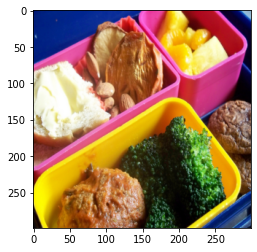

Captions

('Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.')

NN classes

['bell pepper', 'cauliflower', 'mixing bowl', 'cucumber, cuke', 'grocery store, grocery, food market, market']


# 3


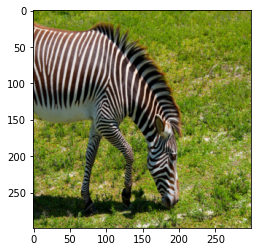

Captions

('A zebra grazing on lush green grass in a field.', 'Zebra reaching its head down to ground where grass is. ', 'The zebra is eating grass in the sun.', 'A lone zebra grazing in some green grass.', 'a Zebra grazing on grass in a green open field.')

NN classes

['zebra', 'hartebeest', 'ostrich, Struthio camelus', 'prairie chicken, prairie grouse, prairie fowl', 'African elephant, Loxodonta africana']


# 6


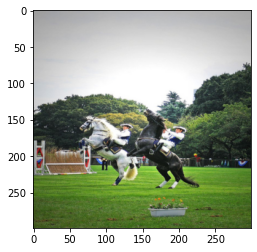

Captions

('A couple of men riding horses on top of a green field.', 'two horses and their riders on some grass', 'Two men are on horses that are reared back.', 'A pair of horses performing tricks in a field. ', 'Two costumed horse riders make their horses stand on their hind legs.')

NN classes

['shield, buckler', 'EntleBucher', 'Greater Swiss Mountain dog', 'cannon', 'parachute, chute']


# 9


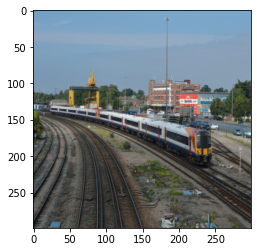

Captions

('A train coming to a stop on the tracks out side.', 'The very long train is travelling down the tracks.', 'A passenger train glides around a curve on the outer track.', 'A train coming down the tracks in the city.', 'A train engine carrying many carts down a track.')

NN classes

['steam locomotive', 'freight car', 'electric locomotive', 'passenger car, coach, carriage', 'traffic light, traffic signal, stoplight']


In [18]:
import requests


img_batch, capt_batch = next(iter(data_loader))

# captions batch is transposed in our version. Check if the same is true for yours
with torch.no_grad():
    capt_batch = list(zip(*capt_batch))
    img_batch = Variable(img_batch)
    vec_batch_for_attn, vec_batch, logits_batch = (var.cpu().data.numpy() for var in model(img_batch))

    print(
        'NN shapes\n\n'
        f'before_pool: {vec_batch_for_attn.shape}\n'
        f'after_pool:  {vec_batch.shape}\n'
        f'logits:      {logits_batch.shape}'
    )

    # class labels
    LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
    labels = {
        int(key): value
        for (key, value)
        in requests.get(LABELS_URL).json().items()
    }

    for i in range(0, 10, 3):
        top_ix = (-logits_batch[i]).argsort()

        print(f"\n\n# {i}")
        plt.imshow(img_batch[i].data.cpu().numpy().transpose([1, 2, 0]))
        plt.show()
        print(
            'Captions\n\n'
            f'{capt_batch[i]}\n\n'
            'NN classes\n\n'
            f'{list(map(labels.get, top_ix[:5]))}'
        )

# Actually transforming data

Note: this part may consume a lot of RAM. If your's a bit limited:
* Do not store vectors that you don't need (e.g. vectors_before_pool if no attention)
* Save everything on a disk every K iterations and free the memory.
    * They ya'll have to manually read it.

In [20]:
from tqdm import tqdm


vectors_before_pool = []
vectors = []
logits = []
captions = []

with torch.no_grad():
    for img_batch, capt_batch in tqdm(data_loader):

        img_batch = Variable(img_batch)
        vec_batch_for_attn, vec_batch, logits_batch  = (var.cpu().data.numpy() for var in model(img_batch))
        capt_batch = zip(*capt_batch)


        logits.extend(logits_batch)

        captions.extend(capt_batch)
        vectors.extend(vec_batch)

        ## WARNING! If you're low on ram, comment this line.
        vectors_before_pool.extend(vec_batch_for_attn)


100%|██████████| 3697/3697 [05:45<00:00, 10.69it/s]


In [22]:
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()

captions_tokenized = [
    [
        ' '.join(filter(len, tokenizer.tokenize(cap.lower())))
        for cap in img_captions
    ]
    for img_captions in tqdm(captions)
]

100%|██████████| 118287/118287 [00:23<00:00, 4938.94it/s]


In [24]:
i = 123
END_LINE = '\n'

print(
    f"Original:\n{END_LINE.join(captions[i])}\n\n\n"
    f"Tokenized:\n{END_LINE.join(captions_tokenized[i])}\n\n"
)

Original:
A young man riding a skateboard down a ramp.
A person standing on a skateboard and skating at a park.
A teenager riding a skateboard at a skate park.
A man riding a skateboard on a ramp.
A kid on a skate board riding on a ramp.


Tokenized:
a young man riding a skateboard down a ramp .
a person standing on a skateboard and skating at a park .
a teenager riding a skateboard at a skate park .
a man riding a skateboard on a ramp .
a kid on a skate board riding on a ramp .




# Save everything
May take a couple of minutes depending on hdd/sdd speed.

In [25]:
!mkdir -p data

import json


np.save("./data/image_codes.npy", np.asarray(vectors))
np.save("./data/image_codes_for_attn.npy", np.asarray(vectors_before_pool))
np.save('./data/image_logits.npy', np.asarray(logits))

with open('./data/captions.json', 'w') as f_cap:
    json.dump(captions, f_cap)
with open('./data/captions_tokenized.json', 'w') as f_cap:
    json.dump(captions_tokenized, f_cap)

In [26]:
# sanity check
!du -h --max-depth=1 .
!ls -lht data

844K	./.ipynb_checkpoints
788M	./val2017
19G	./train2017
796M	./annotations
60G	./data
98G	.
total 60G
-rw-rw-r-- 1 asonin asonin  33M May 26 17:33 captions_tokenized.json
-rw-rw-r-- 1 asonin asonin  33M May 26 17:33 captions.json
-rw-rw-r-- 1 asonin asonin 452M May 26 17:33 image_logits.npy
-rw-rw-r-- 1 asonin asonin  58G May 26 17:32 image_codes_for_attn.npy
-rw-rw-r-- 1 asonin asonin 925M May 26 17:25 image_codes.npy
